# "Interpretable and tractable models of transcriptional noise for the rational design of single-molecule quantification experiments"
## by Gennady Gorin<sup>*</sup>, John Vastola<sup>*</sup>, Meichen Fang, and Lior Pachter
### <sup>*</sup> These authors contributed equally to this work.
# Companion notebook for Figure 2

This notebook is self-contained, and generates plots used in panel b. of Figure 2.

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
# Scientific computing imports
import numpy as np
from scipy.fft import irfft, irfftn
from scipy.stats import nbinom, poisson
from scipy.stats import gamma as gammadist
import scipy.io as sio

# Plotting
import matplotlib.pyplot as plt

------------------------------

## Functions

### $\Gamma$-OU likelihood function

In [3]:
# Get 1 species GOU generating function using ODE method
def get_gf_GOU_1sp_ODE(g, params):
    gamma, kappa, theta, a = params[0], params[1], params[2], params[3]     # get parameters
    
    max_fudge = 10                                                 # Determine integration time scale / length
    t_max = np.max([1/kappa, 1/gamma, 1/theta, 1/a])*max_fudge
    min_fudge = 1   # good: 0.1
    dt = np.min([1/kappa, 1/gamma, 1/theta, 1/a])*min_fudge
    num_tsteps = int(np.ceil(t_max/dt))

    q = np.zeros((g.shape[0], num_tsteps + 1), dtype=np.complex64)    # initialize array to store ODE
    
    t_array = np.linspace(0, t_max, num_tsteps+1)
    t_array = t_array.reshape((1, num_tsteps + 1))
    g = g.reshape((g.shape[0],1))
    q = theta*g*(np.exp(-gamma*t_array) - np.exp(-kappa*t_array))/(kappa - gamma)
    integrand = q/(1-q)
    integral = np.trapz(integrand, dx=dt, axis=1)     # integrate ODE solution
    gf = np.exp(a* integral)               # get generating function
        
    return gf


# Get Pss for 1 species GOU model via ODE method
def get_GOU_analytic(mx, params):
    half = mx[0]//2 + 1
    l = np.arange(half) 
    u = np.exp(-2j*np.pi*l/mx[0])-1                # Choose values of g on unit circle
       
    gf = get_gf_GOU_1sp_ODE(u, params)             # Get generating function
 
    Pss = irfft(gf, n=mx[0])                       # inverse rFFT
    Pss = np.abs(Pss)/np.sum(np.abs(Pss))          # normalize
    return Pss


### CIR likelihood function

In [4]:
# ODE for 1 species model
def f_1sp(q, t, g, params):
    gamma, kappa, theta, a = params
    
    result = - kappa*q + (kappa*theta)*q*q + g*np.exp(-gamma*t)
    return result


# RK4 implementation for 1 species model
def RK4_1sp(q, f, t, g, step_size, param):
    j1 = f(q, t, g, param)
    j2 = f(q + (step_size/2)*j1, t + (step_size/2), g, param)   
    j3 = f(q + (step_size/2)*j2, t + (step_size/2), g, param)   
    j4 = f(q + (step_size)*j3, t + (step_size), g, param)  
    q_new = q + (step_size/6)*(j1 + 2*j2 + 2*j3 + j4)
  
    return q_new


# Get 1 species CIR generating function using ODE method
def get_gf_CIR_1sp_ODE(g, params):
    gamma, kappa, theta, a = params[0], params[1], params[2], params[3]     # get parameters
    
    max_fudge = 10                                                 # Determine integration time scale / length
    t_max = np.max([1/kappa, 1/gamma, 1/theta, 1/a])*max_fudge
    min_fudge = 1   # good: 0.1
    dt = np.min([1/kappa, 1/gamma, 1/theta, 1/a])*min_fudge
    num_tsteps = int(np.ceil(t_max/dt))

    q = np.zeros((g.shape[0], num_tsteps + 1), dtype=np.complex64)    # initialize array to store ODE
    
    # Solve ODE using RK4
    for i in range(0, num_tsteps):
        t = i*dt
        q[:,i+1] = RK4_1sp(q[:,i], f_1sp, t, g, dt, params)
    
    integral = np.trapz(q, dx=dt, axis=1)     # integrate ODE solution
    gf = np.exp(a*theta*integral)               # get generating function
        
    return gf


# Get Pss for 1 species CIR model via ODE method
def get_CIR_analytic(mx, params):
    half = mx[0]//2 + 1
    l = np.arange(half) 
    u = np.exp(-2j*np.pi*l/mx[0])-1                # Choose values of g on unit circle
       
    gf = get_gf_CIR_1sp_ODE(u, params)             # Get generating function
 
    Pss = irfft(gf, n=mx[0])                       # inverse rFFT
    Pss = np.abs(Pss)/np.sum(np.abs(Pss))          # normalize
    return Pss

### Exact likelihood functions for limiting cases (constitutive, mixture, high gain $\Gamma$-OU, high gain CIR)

In [5]:
# Constitutive model likelihood (just a Poisson distribution)
def get_const_nascent(x, params):
    gamma, kappa, theta, a = params
    K_avg = (a*theta)/kappa
    mu = K_avg/gamma
    
    return poisson.pmf(x, mu)


# Mixture / slow mean-reversion model likelihood (just a negative binomial distribution)
def get_slowrev_nascent(x, params):
    gamma, kappa, theta, a = params
    r = a/kappa
    p = 1/(1 + theta) 
    
    return nbinom.pmf(x, n=r, p=p)


# High gain GOU model likelihood (also just a negative binomial distribution, but with different parameters)
def get_highgain_GOU_nascent(x, params):
    gamma, kappa, theta, a = params
    r = a/gamma
    p = kappa/(kappa + theta) 
    
    return nbinom.pmf(x, n=r, p=p)


# High gain CIR model likelihood (more complicated than the others; not a well-characterized parametric family)
def get_highgain_CIR_nascent(mx, params):
    gamma, kappa, theta, a = params
    b = theta/kappa
    
    half = mx[0]//2 + 1
    l = np.arange(half) 
    g = np.exp(-2j*np.pi*l/mx[0])-1                # Choose values of g on unit circle
    
    max_fudge = 10                                                 # Determine integration time scale / length
    t_max = np.max([1/kappa, 1/gamma, 1/theta, 1/a])*max_fudge
    min_fudge = 1   # good: 0.1
    dt = np.min([1/kappa, 1/gamma, 1/theta, 1/a])*min_fudge
    num_tsteps = int(np.ceil(t_max/dt))

    q = np.zeros((g.shape[0], num_tsteps + 1), dtype=np.complex64)    # initialize array to store ODE
    
    t_array = np.linspace(0, t_max, num_tsteps+1)
    t_array = t_array.reshape((1, num_tsteps + 1))
    g = g.reshape((g.shape[0],1))
    q = 1 - np.sqrt(1 - 4*b*g*np.exp(-gamma*t_array) )
    integrand = q
    integral = np.trapz(integrand, dx=dt, axis=1)     # integrate ODE solution
    gf = np.exp((a/2)* integral)               # get generating function
    
    Pss = irfft(gf, n=mx[0])                       # inverse rFFT
    Pss = np.abs(Pss)/np.sum(np.abs(Pss))          # normalize
    return Pss

----------------------------------------------------------------------------

## Sample plot of limiting cases

Set up parameters.

In [6]:
mx = [60]       # domain size

gamma = 1    # splicing rate (or, in 1 species case, degradation rate)
a = 1            # a*theta is ext. noise production rate
kappa = 0.5      # extrinsic noise time scale / decay rate 
theta = 5             # theta is scale parameter of Gamma dist. Bigger = more spread out transcription rate values
params = [gamma, kappa, theta, a]

x = np.arange(mx[0])

Compute exact probability distributions.

In [7]:
p_const_nascent = get_const_nascent(x, params)
p_slowrev_nascent = get_slowrev_nascent(x, params)
p_highgain_GOU_nascent = get_highgain_GOU_nascent(x, params)
p_highgain_CIR_nascent = get_highgain_CIR_nascent(mx, params)

Plot sample results.

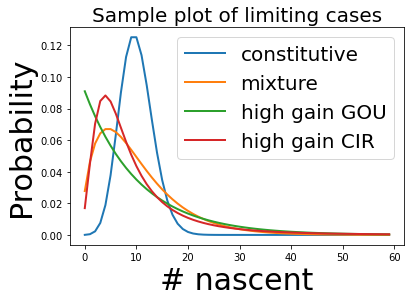

In [8]:
# plot results
plt.plot(x, p_const_nascent, linewidth=2, label='constitutive')
plt.plot(x, p_slowrev_nascent, linewidth=2, label='mixture')
plt.plot(x, p_highgain_GOU_nascent, linewidth=2, label='high gain GOU')
plt.plot(x, p_highgain_CIR_nascent, linewidth=2, label='high gain CIR')
plt.xlabel("# nascent", fontsize=30)
plt.ylabel('Probability', fontsize=30)
plt.title("Sample plot of limiting cases", fontsize=20)
plt.legend(fontsize=20, loc='upper right')
plt.show()

----------------------------------

## Plot panels used in Figure 2

Get names of external simulation data sets used.

In [9]:
names = ['data/cir_3_poisson.mat', 'data/gou_2_extrinsic.mat', 'data/gou_1_intrinsic.mat', 'data/cir_1_intrinsic.mat']
N = len(names)

Function that imports external data.

In [10]:
IND_ = [4, 6, 18, 18]           # indices of relevant features

def get_data(i):
    F = sio.loadmat(names[i])
    X_s = F['X_s'][:,0,:].astype('int')
    tvec = F['tvec_sde'][0]
    
    K_t = F['SDE_t'][IND_[i],:]
    
    x_N = X_s[:,0]
    x_M = X_s[:,1]
    
    x_N_max = np.max(x_N)
    x_M_max = np.max(x_M)
    
    x_N_bins = np.arange(x_N_max + 2) - 0.5
    x_M_bins = np.arange(x_M_max + 1) - 0.5
    
    kappa = F['kappa'][0,0]
    alpha = F['alpha'][0][0]
    a = alpha*kappa
    theta = 1/F['eta'][0,0]
    beta = 1.2
    gamma = F['gamma'][0][0]
    
    params = [beta, kappa, theta, a]
    
    x_N_arg = np.arange(x_N_max + 1)
    
    return params, tvec, K_t, x_N, x_N_bins, x_N_arg

Get external data.

In [11]:
# constitutive data
params_const, tvec_const, K_t_const, x_N_const, x_N_bins_const, x_N_arg_const = get_data(0)

# slow reversion data
params_slowrev, tvec_slowrev, K_t_slowrev, x_N_slowrev, x_N_bins_slowrev, x_N_arg_slowrev = get_data(1)

# geometric bursts data
params_gb, tvec_gb, K_t_gb, x_N_gb, x_N_bins_gb, x_N_arg_gb = get_data(2)

# quasi-bursty data
params_qb, tvec_qb, K_t_qb, x_N_qb, x_N_bins_qb, x_N_arg_qb = get_data(3)

Histogram bin plotting preferences.

In [12]:
manual_cap = 6
manual_bins =  np.arange(manual_cap + 2) - 0.5
x_manual = np.arange(manual_cap + 1)
mx_manual = [manual_cap]

t_min = 0

Produce plots for Figure 2.

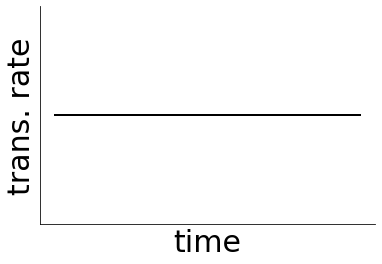

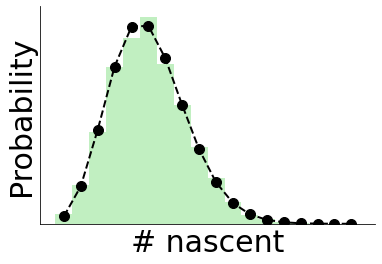

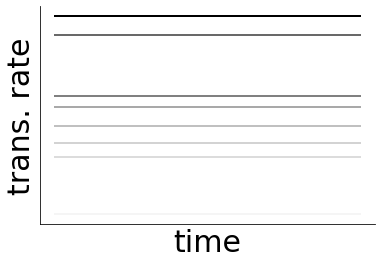

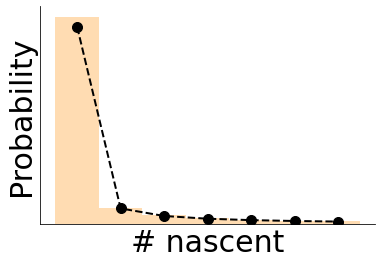

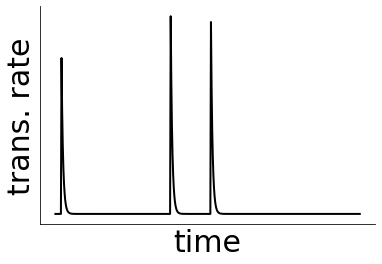

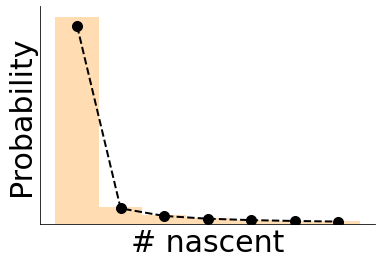

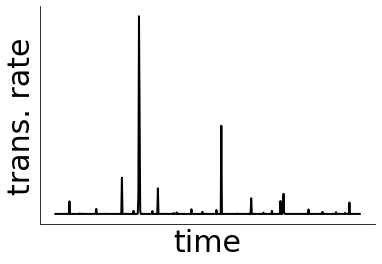

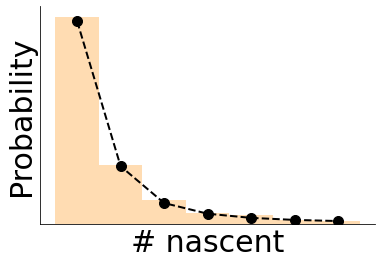

In [13]:
# CONSTITUTIVE PLOT
ax = plt.subplot(111)
p_const_nascent = get_const_nascent(x_N_arg_const, params_const)

t_len = len(tvec_const)
beta, kappa, theta, a = params_const
K_avg = (a*theta/kappa)
K_const = K_avg*np.ones(t_len)


plt.plot(tvec_const, K_const, color='black', linewidth=2)
plt.xlabel('time', fontsize=30)
plt.ylabel('trans. rate', fontsize=30)
plt.xticks([])
plt.yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('results/K_const.png')
plt.savefig('results/K_const.pdf')
plt.show()

ax = plt.subplot(111)
plt.hist(x_N_const, density=True, bins=x_N_bins_const, color='limegreen', alpha=0.3)
plt.plot(x_N_arg_const, p_const_nascent, linewidth=2, color='black', linestyle='--')
plt.scatter(x_N_arg_const, p_const_nascent,color='black',zorder=3, s= 100)
plt.xlabel('# nascent', fontsize=30)
plt.ylabel('Probability', fontsize=30)
plt.xticks([])
plt.yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('results/p_nascent_const.png')
plt.savefig('results/p_nascent_const.pdf')
plt.show()
    
    
    
# SLOWREV PLOT

np.random.seed(10)
t_len = len(tvec_slowrev)
num_samples = 8
gamma, kappa, theta, a = params
r = a/kappa
p = 1/(1 + theta) 
K_vals = gammadist.rvs(a/kappa, loc=0, scale=theta, size=num_samples, random_state=None)

K_vals = np.sort(K_vals)

colors = ['whitesmoke', 'gainsboro', 'lightgray', 'silver', 'darkgray', 'gray', 'dimgray', 'black']
K_pop = np.zeros((num_samples, t_len))
for i in range(num_samples):
    K_pop[i,:] = K_vals[i]*np.ones(t_len)


ax = plt.subplot(111)
p_slowrev_nascent = get_slowrev_nascent(x_N_arg_slowrev, params_slowrev)[:manual_cap + 1]

for i in range(num_samples):
    plt.plot(tvec_slowrev, K_pop[i,:], color=colors[i], linewidth=2)
plt.xlabel('time', fontsize=30)
plt.ylabel('trans. rate', fontsize=30)
plt.xticks([])
plt.yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('results/K_slowrev.png')
plt.savefig('results/K_slowrev.pdf')
plt.show()

ax = plt.subplot(111)
plt.hist(x_N_slowrev, density=True, bins=manual_bins, color='darkorange', alpha=0.3)
plt.plot(x_manual, p_slowrev_nascent, linewidth=2, color='black', linestyle='--')
plt.scatter(x_manual, p_slowrev_nascent,color='black',zorder=3, s= 100)
plt.xlabel('# nascent', fontsize=30)
plt.ylabel('Probability', fontsize=30)
plt.xticks([])
plt.yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('results/p_nascent_slowrev.png')
plt.savefig('results/p_nascent_slowrev.pdf')
plt.show()



# HIGH GAIN GOU PLOT
ax = plt.subplot(111)
p_gb_nascent = get_highgain_GOU_nascent(x_N_arg_gb, params_gb)[:manual_cap + 1]
plt.plot(tvec_gb[t_min:], K_t_gb[t_min:], color='black', linewidth=2)
plt.xlabel('time', fontsize=30)
plt.ylabel('trans. rate', fontsize=30)
plt.xticks([])
plt.yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('results/K_gb.png')
plt.savefig('results/K_gb.pdf')
plt.show()

ax = plt.subplot(111)
plt.hist(x_N_gb, density=True, bins=manual_bins, color='darkorange', alpha=0.3)
plt.plot(x_manual, p_gb_nascent, linewidth=2, color='black', linestyle='--')
plt.scatter(x_manual, p_gb_nascent,color='black',zorder=3, s= 100)
plt.xlabel('# nascent', fontsize=30)
plt.ylabel('Probability', fontsize=30)
plt.xticks([])
plt.yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('results/p_nascent_gb.png')
plt.savefig('results/p_nascent_gb.pdf')
plt.show()



# HIGH GAIN CIR PLOT
ax = plt.subplot(111)
p_qb_nascent = get_highgain_CIR_nascent([30], params_gb)[:manual_cap+1]
plt.plot(tvec_qb, K_t_qb, color='black', linewidth=2)
plt.xlabel('time', fontsize=30)
plt.ylabel('trans. rate', fontsize=30)
plt.xticks([])
plt.yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('results/K_qb.png')
plt.savefig('results/K_qb.pdf')
plt.show()

ax = plt.subplot(111)
plt.hist(x_N_qb, density=True, bins=manual_bins, color='darkorange', alpha=0.3)
plt.plot(x_manual, p_qb_nascent, linewidth=2, color='black', linestyle='--')
plt.scatter(x_manual, p_qb_nascent,color='black',zorder=3, s= 100)
plt.xlabel('# nascent', fontsize=30)
plt.ylabel('Probability', fontsize=30)
plt.xticks([])
plt.yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('results/p_nascent_qb.png')
plt.savefig('results/p_nascent_qb.pdf')
plt.show()

    